In [32]:
import pandas as pd
import pandas_profiling
import os
import pickle
import gc
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

#データ読み込み
train = pd.read_csv("data_EDA/train.csv")
test = pd.read_csv("data_EDA/test.csv")

In [29]:
test.describe()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,...,Insulin_na,Pregnancies_na,Pre/age,SkinThickness_mean,BloodPressure_mean,Insulin_dpf_mean,Pregnancies_bin_0,Pregnancies_bin_-1,Pregnancies_bin_-3,Pregnancies_bin_3-
count,2000.000000,2000.000000,2000.00000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,0.0,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,2509.303000,3.584000,114.29350,68.76650,11.204000,11.859000,35.586624,0.401755,29.075500,NaN,...,0.919000,0.036500,0.120309,26.710875,71.372937,136.508818,0.119500,0.355000,0.273000,0.252500
std,1438.260835,3.053786,21.98925,16.17482,14.056037,49.826253,6.936853,0.267051,8.571729,NaN,...,0.272903,0.187578,0.099192,5.127628,9.077127,29.914680,0.324457,0.478633,0.445612,0.434555
min,1.000000,0.000000,57.00000,0.00000,0.000000,0.000000,9.285680,0.137377,21.000000,NaN,...,0.000000,0.000000,0.000000,8.000000,38.000000,15.000000,0.000000,0.000000,0.000000,0.000000
25%,1284.750000,1.000000,100.00000,64.00000,0.000000,0.000000,32.581209,0.234628,22.000000,NaN,...,1.000000,0.000000,0.045455,26.875000,64.000000,135.636364,0.000000,0.000000,0.000000,0.000000
50%,2549.500000,3.000000,111.00000,70.00000,0.000000,0.000000,33.814634,0.271275,26.000000,NaN,...,1.000000,0.000000,0.097168,26.875000,71.409223,135.636364,0.000000,0.000000,0.000000,0.000000
75%,3743.750000,6.000000,125.00000,78.00000,24.250000,0.000000,39.694403,0.506439,33.000000,NaN,...,1.000000,0.000000,0.171675,26.875000,78.000000,135.636364,0.000000,1.000000,1.000000,1.000000
max,4995.000000,13.000000,199.00000,110.00000,52.000000,744.000000,52.960258,2.175784,67.000000,NaN,...,1.000000,1.000000,0.590909,52.000000,110.000000,744.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
train.describe()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,...,Insulin_na,Pregnancies_na,Pre/age,SkinThickness_mean,BloodPressure_mean,Insulin_dpf_mean,Pregnancies_bin_0,Pregnancies_bin_-1,Pregnancies_bin_-3,Pregnancies_bin_3-
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000
mean,2492.964667,3.557000,113.733667,68.743667,11.164000,11.663333,35.408959,0.400476,28.932000,0.239000,...,0.914667,0.037667,0.120089,26.984417,71.433414,135.725394,0.143333,0.330667,0.272000,0.25400
std,1447.218078,3.032131,20.885612,16.332755,14.351159,45.064090,6.990180,0.274666,8.469078,0.426544,...,0.279424,0.190421,0.100340,5.248441,9.040411,23.922032,0.350471,0.470532,0.445064,0.43537
min,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000,7.748040,0.145844,21.000000,0.000000,...,0.000000,0.000000,0.000000,7.000000,46.000000,15.000000,0.000000,0.000000,0.000000,0.00000
25%,1218.750000,1.000000,100.000000,64.000000,0.000000,0.000000,32.301920,0.230987,22.000000,0.000000,...,1.000000,0.000000,0.045455,26.875000,64.000000,135.636364,0.000000,0.000000,0.000000,0.00000
50%,2465.500000,3.000000,111.000000,70.000000,0.000000,0.000000,33.835873,0.268674,26.000000,0.000000,...,1.000000,0.000000,0.098780,26.875000,71.409223,135.636364,0.000000,0.000000,0.000000,0.00000
75%,3750.250000,6.000000,125.000000,78.000000,24.000000,0.000000,39.578256,0.506778,33.000000,0.000000,...,1.000000,0.000000,0.172414,26.875000,78.000000,135.636364,0.000000,1.000000,1.000000,1.00000
max,4999.000000,13.000000,196.000000,110.000000,49.000000,579.000000,53.400629,2.302072,67.000000,1.000000,...,1.000000,1.000000,0.619048,49.000000,110.000000,579.000000,1.000000,1.000000,1.000000,1.00000


In [31]:
# まずは少ない特徴量から検討していく
X_train = train[['DiabetesPedigreeFunction',
                 'BMI',
                 'Glucose',
                 'Age',
                 'Pregnancies',
                 'SkinThickness',
                 'Insulin',
                 'BloodPressure',
                 'Pre/age',
                 
                 
                
             ]]
id_train = train[['index']]
y_train = train[['Outcome']]


X_test = test[X_train.columns]
id_test = test[id_train.columns]

In [24]:
# 数値データ
col_num = X_train.columns[X_train.dtypes!='object'].values.tolist()

dict_num = {}
for col in col_num:
    print(col)
    # 欠損値を0へ
    value_fillna = 0 
    X_train[col] = X_train[col].fillna(value_fillna)
    # 正規化
    value_min = X_train[col].min()
    value_max = X_train[col].max()
    value_mean = X_train[col].mean()
    value_std = X_train[col].std()
    X_train[col] = (X_train[col] - value_min) / (value_max -value_min)
    # X_tarin[col] = (X_train[col] - value_mean) / value_std
    
    dict_num[col] = {}
    dict_num[col]['fillna'] = value_fillna
    dict_num[col]['min'] = value_min
    dict_num[col]['max'] = value_max
    dict_num[col]['mean'] = value_max    
    dict_num[col]['std'] = value_max    
    
print('Done')

DiabetesPedigreeFunction
BMI
Glucose
Age
Pregnancies
SkinThickness
Insulin
BloodPressure
Pre/age
Done


In [25]:
# カテゴリデータ
# （embedding予定でラベルエンコーダー）
col_cat = X_train.columns[X_train.dtypes=='object'].values.tolist()

dict_cat = {}
for col in col_cat:
    print(col)
    value_fillna = 'unknown'
    X_train[col] = X_train[cal].fillna(value_fillna)
    
    X_train[caol] = X_train[col].astype(str)
    # strに変換
    le = LabelEncorder()
    le.fit(X_train[col])
    list_labelsorted(list(set(le.classes_) | set(['unknown'])))
    map_label = {j:i for i,j in enumerate(list_label)}
    X_train[col] = X_train[col].map(map_label)
    
    dict_cat[col] = {}
    dict_cat[col]['fillna'] = value_fillna
    dict_cat[col]['map_label'] = map_label
    dict_cat[col]['num_label'] = len(list_label)

print('Done')


Done


In [26]:
def transform_data(input_x):
    output_x = input_x.copy()
    
    for col in col_num:
        value_fillna = dict_num[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        value_min = dict_num[col]['min']
        value_max = dict_num[col]['max']
        output_x[col]  = (output_x[col] - value_min ) / (value_max - value_min)
        
    for col in col_cat:
        value_fillna = dict_cat[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        output_x[col] = output_x[col].astype(str)
        
        map_label = dict_catt[col]['map_label']
        output_x[col] = output_x[col].map(map_label)
        
        #対応するものがない場合はunkoumn
        output_x[col] = output_x[col].fillna(map_label['unknown'])
        
    return output_x

X_test = transform_data(X_test)

In [27]:
X_train.describe()

,DiabetesPedigreeFunction,BMI,Glucose,Age,Pregnancies,SkinThickness,Insulin,BloodPressure,Pre/age
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.118091,0.605900,0.408156,0.172435,0.273615,0.227837,0.020144,0.624942,0.193989
std,0.127383,0.153117,0.150256,0.184110,0.233241,0.292881,0.077831,0.148480,0.162087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.039487,0.537842,0.309353,0.021739,0.076923,0.000000,0.000000,0.581818,0.073427
50%,0.056965,0.571443,0.388489,0.108696,0.230769,0.000000,0.000000,0.636364,0.159568
75%,0.167392,0.697227,0.489209,0.260870,0.461538,0.489796,0.000000,0.709091,0.278515
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
X_test.describe()

,DiabetesPedigreeFunction,BMI,Glucose,Age,Pregnancies,SkinThickness,Insulin,BloodPressure,Pre/age
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.118685,0.609792,0.412183,0.175554,0.275692,0.228653,0.020482,0.625150,0.194345
std,0.123851,0.151949,0.158196,0.186342,0.234907,0.286858,0.086056,0.147044,0.160233
min,-0.003927,0.033681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.041176,0.543960,0.309353,0.021739,0.076923,0.000000,0.000000,0.581818,0.073427
50%,0.058171,0.570977,0.388489,0.108696,0.230769,0.000000,0.000000,0.636364,0.156963
75%,0.167234,0.699771,0.489209,0.260870,0.461538,0.494898,0.000000,0.709091,0.277321
max,0.941431,0.990354,1.021583,1.000000,1.000000,1.061224,1.284974,1.000000,0.954545


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD

random_state=123

2023-03-15 19:14:11.886831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 19:14:13.234390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 19:14:13.234486: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-15 19:14:13.377591: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-15 19:14:17.048827: W tensorflow/stream_executor/platform/de

In [22]:
def seed_everything(seed):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

## NNでの評価（CV)

In [23]:
def create_model():
    input_num = Input(shape=(8,))
    x_num = Dense(10, activation='relu')(input_num)
    x_num = BatchNormalization()(x_num)
    x_num = Dropout(0.3)(x_num)
    x_num = Dense(10, activation='relu')(x_num)
    x_num = BatchNormalization()(x_num)
    x_num = Dropout(0.2)(x_num)
    x_num = Dense(5, activation='relu')(x_num)
    x_num = BatchNormalization()(x_num)
    x_num = Dropout(0.1)(x_num)
    out = Dense(1, activation='sigmoid')(x_num)
    
    model = Model(inputs=input_num, outputs=out,)
    
    model.compile(
        optimizer='Adam',
        loss='binary_crossentropy',
        metrics=['binary_crossentropy'],
    )
    
    return model

In [24]:
# モデルの確認
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 10)                90        
                                                                 
 batch_normalization (BatchN  (None, 10)               40        


2023-03-15 19:14:20.740339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-15 19:14:20.741727: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 19:14:20.741802: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3ed327de65ae): /proc/driver/nvidia/version does not exist
2023-03-15 19:14:20.744296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 batch_normalization_1 (Batc  (None, 10)               40        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 batch_normalization_2 (Batc  (None, 5)                20        
 hNormalization)                                                 
          

In [28]:
# cvでの評価用
def train_nn(input_x,
              input_y,
              input_id,
              list_nfold=[0,1,2,3,4],
              n_splits=5,
              random_state=123
            ):
    train_oof = np.zeros(len(input_x))
    # foldごとの推論値
    metrics = []
    imp = pd.DataFrame()
                         
    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).
              split(input_x, input_y))
    
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print('y_train:{:.3f}, y_tr:{:.3f}, y_va{:.3f}'.
              format(y_train['Outcome'].mean(), y_tr['Outcome'].mean(), y_va['Outcome'].mean(),))

        model = create_model()
        model.fit(x=x_tr,
                  y=y_tr,
                 validation_data=(x_va, y_va),
                 batch_size=8,
                 epochs=1000,
                 callbacks=[ModelCheckpoint(filepath='model_keras.h5',
                                            moniter='val_loss',
                                            mode='min', 
                                            verbose=1,
                                            save_best_only=True,
                                            ),
                            EarlyStopping(monitor='val_loss',
                                          mode='min',
                                          min_delta=0,
                                          patience=5,
                                          verbose=1,
                                          restore_best_weights=True),
                            ReduceLROnPlateau(moniter='val_loss',
                                             mode='min',
                                             factor=0.1,
                                             patience=5,
                                             verbose=1),
                           ],
                  verbose=1,
                 )

        # モデルの保存
        fname_nn = 'model/nn/model_nn_fold{}.pickle'.format(nfold)
        with open(fname_nn, 'wb')as f:
            pickle.dump(model, f, protocol=4)
            
            
        # 評価
        y_tr_pred = model.predict(x_tr)
        y_va_pred = model.predict(x_va)
        metric_tr = accuracy_score(y_tr, np.where(y_tr_pred>=0.5,1,0))
        metric_va = accuracy_score(y_va, np.where(y_va_pred>=0.5,1,0))
        print('[accuracy] tr: {:.2f}, va: {:2f}'.
             format(metric_tr, metric_va))
        metrics.append([nfold, metric_tr, metric_va])
        
        # oof
        train_oof[idx_va] = np.squeeze(y_va_pred)
        
        
        print('-'*20, 'result', '-'*20)
    
    # metrix出力
    metrics = np.array(metrics)
    print(metrics)
    print('[cv] tr: {:.2f}+-{:.2f}, va: {:.2f}'.format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std()
    ))
    print('[oof] {:.4f}'.format(
        accuracy_score(input_y, np.where(train_oof>=0.5,1,0))))
    # oof出力  
    train_oof = pd.concat([
        input_id,
        pd.DataFrame({'pred':train_oof})]
        ,axis=1)

    print('Done')
    
    return train_oof, metrics

In [47]:
params = dict(n_d=8, n_a=8, n_steps=3, gamma=1.3,
                     n_independent=2, n_shared=2,
                     seed=SEED, lambda_sparse=1e-3, 
                     optimizer_fn=torch.optim.Adam, 
                     optimizer_params=dict(lr=2e-2),
                     mask_type="entmax",
                     scheduler_params=dict(mode="min",
                                           patience=5,
                                           min_lr=1e-5,
                                           factor=0.9,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=10
                    )

In [29]:
train_oof, metrics = train_nn(X_train, y_train, id_train, list_nfold=[0,1,2,3,4], n_splits=5, random_state=123)

-------------------- 0 --------------------
(2400, 8) (2400, 1)
(600, 8) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.240
Epoch 1/1000
300/300 [==============================] - ETA: 0s - loss: 0.6972 - binary_crossentropy: 0.6972
Epoch 1: val_loss improved from inf to 0.54997, saving model to model_keras.h5
300/300 [==============================] - 3s 7ms/step - loss: 0.6972 - binary_crossentropy: 0.6972 - val_loss: 0.5500 - val_binary_crossentropy: 0.5500 - lr: 0.0010
Epoch 2/1000
290/300 [============================>.] - ETA: 0s - loss: 0.5837 - binary_crossentropy: 0.5837
Epoch 2: val_loss improved from 0.54997 to 0.51006, saving model to model_keras.h5
300/300 [==============================] - 2s 5ms/step - loss: 0.5814 - binary_crossentropy: 0.5814 - val_loss: 0.5101 - val_binary_crossentropy: 0.5101 - lr: 0.0010
Epoch 3/1000
299/300 [============================>.] - ETA: 0s - loss: 0.5496 - binary_crossentropy: 0.5496
Epoch 3: val_loss improved from 0.51006 to 0.50196, saving m

In [30]:
train_oof[:3]

,index,pred
0,200,0.384083
1,3832,0.104301
2,4927,0.444559


## 推論

In [37]:
def predict_nn(input_x,
               input_id,
               list_nfold=[0,1,2,3,4],
               ):
    pred = np.zeros((len(input_x), len(list_nfold)))
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        fname_nn = 'model/nn/model_nn_fold{}.pickle'.format(nfold)
        with open(fname_nn, 'rb')as f:
            model = pickle.load(f)
        pred[:,nfold] = np.squeeze(model.predict(input_x))
        
    pred = pd.concat([
        input_id,
        pd.DataFrame({'pred':pred.mean(axis=1)}),], axis=1)
    
    print('Done')
    
    return pred

In [38]:
test_pred_proba = predict_nn(X_test,
                    id_test,
                    list_nfold=[0,1,2,3,4],
                   )

-------------------- 0 --------------------
63/63 [==============================] - 0s 3ms/step
-------------------- 1 --------------------
63/63 [==============================] - 0s 3ms/step
-------------------- 2 --------------------
63/63 [==============================] - 0s 3ms/step
-------------------- 3 --------------------
63/63 [==============================] - 0s 3ms/step
-------------------- 4 --------------------
63/63 [==============================] - 0s 3ms/step
Done


In [39]:
test_pred_proba[:3]

,index,pred
0,398,0.221906
1,3833,0.103745
2,4836,0.110308


In [40]:
test_pred = test_pred_proba.copy()  
test_pred['pred']=np.where(test_pred['pred'] < 0.5, 0, 1)
test_pred[:3]

,index,pred
0,398,0
1,3833,0
2,4836,0


In [42]:
train_oof[:3]

,index,pred
0,200,0.384083
1,3832,0.104301
2,4927,0.444559


In [45]:
test_pred.to_csv('sub/submission_nn.csv', index=None, header=False,)

## アンサンブル用データ

In [46]:
import pickle
 
with open('ensamble/nn_train.pickle', mode='wb') as fo:
    pickle.dump(train_oof, fo)
    
with open('ensamble/nn_test.pickle', mode='wb') as fo:
    pickle.dump(test_pred_proba, fo)
    

## ベースライン検証

In [ ]:
x_tr, x_va2, y_tr, y_va2 = train_test_split(X_train,
                                           y_train,
                                           test_size=0.2,
                                           shuffle=True,
                                           stratify=y_train,
                                           random_state=random_state)
print('検証データ: ',x_tr.shape, y_tr.shape)
print('ベースライン検証データ: ',x_va2.shape, y_va2.shape)

x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr,
                                              y_tr,
                                              test_size=0.2,
                                              shuffle=True,
                                              stratify=y_tr,
                                              random_state=random_state)
print('検証データ(train): ',x_tr1.shape, y_tr1.shape)
print('検証データ(test): ',x_va1.shape, y_va1.shape)


In [103]:
#validation結果
pretrainer = TabNetPretrainer(**params)
pretrainer.fit(
    X_train=x_tr1,
    eval_set=[x_va1],
    max_epochs=200,
    patience=20, batch_size=256, virtual_batch_size=128,
    num_workers=1, drop_last=True)
model = TabNetClassifier(**params)
model.fit(
    X_train=x_tr1,
    y_train=y_tr1,
    eval_set=[(x_va1, y_va1)],
    eval_name = ["valid"],
    eval_metric = ["auc"],
    max_epochs=200,
    patience=20, 
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0, 
    drop_last=False,
    from_unsupervised=pretrainer
)

epoch 0  | loss: 5.56109 | val_0_unsup_loss_numpy: 164.60769653320312|  0:00:00s
epoch 10 | loss: 0.91191 | val_0_unsup_loss_numpy: 0.9158899784088135|  0:00:02s
epoch 20 | loss: 0.91583 | val_0_unsup_loss_numpy: 0.8389000296592712|  0:00:04s
epoch 30 | loss: 0.8828  | val_0_unsup_loss_numpy: 0.8041800260543823|  0:00:06s
epoch 40 | loss: 0.82442 | val_0_unsup_loss_numpy: 0.8322700262069702|  0:00:07s
epoch 50 | loss: 0.86601 | val_0_unsup_loss_numpy: 0.8119699954986572|  0:00:09s

Early stopping occurred at epoch 53 with best_epoch = 33 and best_val_0_unsup_loss_numpy = 0.7945299744606018
epoch 0  | loss: 1.27547 | valid_auc: 0.66521 |  0:00:00s
epoch 10 | loss: 0.46441 | valid_auc: 0.70492 |  0:00:01s
epoch 20 | loss: 0.43486 | valid_auc: 0.67533 |  0:00:02s

Early stopping occurred at epoch 27 with best_epoch = 7 and best_valid_auc = 0.72117


[検証データ] acc: 0.7729
[ベースライン検証データ] acc: 0.7667
[検証データ] auc: 0.7212
[ベースライン検証データ] auc: 0.7820


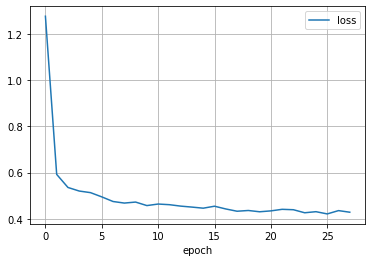

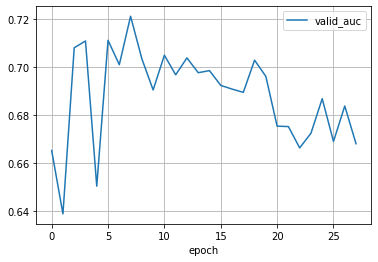

In [104]:
#評価指標の差
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)
print('[検証データ] acc: {:.4f}'.format(accuracy_score(y_va1, y_va1_pred)))
print('[ベースライン検証データ] acc: {:.4f}'.format(accuracy_score(y_va2, y_va2_pred)))

y_va1_pred_proba = model.predict_proba(x_va1)
y_va2_pred_proba = model.predict_proba(x_va2)
print('[検証データ] auc: {:.4f}'.format(roc_auc_score(y_va1, y_va1_pred_proba[:,1])))
print('[ベースライン検証データ] auc: {:.4f}'.format(roc_auc_score(y_va2, y_va2_pred_proba[:,1])))


for param in ['loss', 'valid_auc']:
    plt.plot(model.history[param], label=param)
    plt.xlabel('epoch')
    plt.grid()
    plt.legend()
    plt.show()

In [105]:
#誤分類の分布
print('検証データ')
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize='all'))

print('ベースライン検証データ')
print(confusion_matrix(y_va2, y_va2_pred))
print(confusion_matrix(y_va2, y_va2_pred, normalize='all'))

検証データ
[[324  41]
 [ 68  47]]
[[0.675      0.08541667]
 [0.14166667 0.09791667]]
ベースライン検証データ
[[413  44]
 [ 96  47]]
[[0.68833333 0.07333333]
 [0.16       0.07833333]]


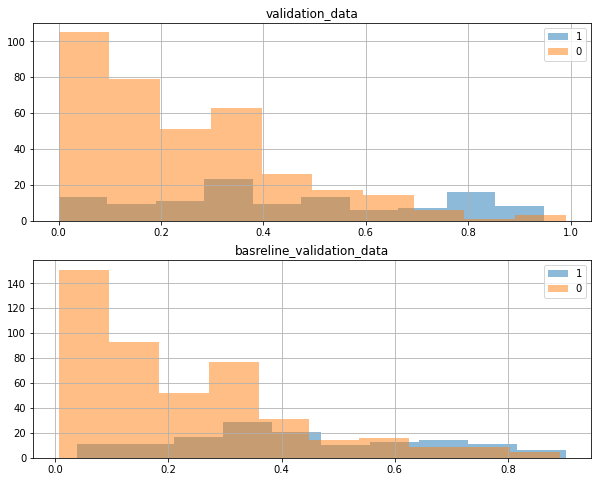

In [106]:
# 予測値の分布
y_va1_pred_prob = model.predict_proba(x_va1)[:,1]
y_va2_pred_prob = model.predict_proba(x_va2)[:,1]

fig = plt.figure(figsize=(10,8))

fig.add_subplot(2,1,1)
plt.title('validation_data')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

fig.add_subplot(2,1,2)
plt.title('basreline_validation_data')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

## チューニング

In [75]:
import optuna

In [76]:
# 探索しないパラメータ

params_base = {
   'optimizer_fn': torch.optim.Adam,
   'optimizer_params': {'lr':2e-2,'weight_decay':1e-5},
   'mask_type': "entmax",#AttentiveTransformerでマスク作るのにどっちの関数を使うか'sparsemax'or'entmax'
   'scheduler_params':{'mode': "min",'patience': 5,'min_lr': 1e-5,'factor': 0.9, 'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,},
   'verbose':10,
   'seed': 123,
}

def objective(trial):
    # 探索するパラメータ
    params_tuning = {
        'n_d': trial.suggest_int('n_d',8,64),
        'n_a': trial.suggest_int('n_a',8,64),
        'n_steps': trial.suggest_int('n_steps', 1, 10),
        'gamma': trial.suggest_float('gamma', 1.0, 2.0),
        'mask_type': trial.suggest_categorical('mask_type', ['entmatx','sparsemax']),
    }
    params_tuning.update(params_base)
    
    # モデル学習・評価
    list_metrics = []
    cv = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state).split(X_train, y_train))
    for nfold in np.arange(4):
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = X_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
        x_va, y_va = X_train.loc[idx_va, :], y_train.loc[idx_va, :]
       
        model = TabNetClassifier(**params)
        model.fit(
            X_train=x_tr,
            y_train=y_tr,
            eval_set=[(x_va, y_va)],
            eval_name = ["valid"],
            eval_metric = ["auc"],
            max_epochs=200,
            patience=20, 
            batch_size=256,
            virtual_batch_size=128,
            num_workers=0, 
            drop_last=False,
            from_unsupervised=pretrainer
        )
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_va = accuracy_score(y_va, np.where(y_va_pred>0.5, 1, 0))
        list_metrics.append(metric_va)
        
    # 評価値の計算
    metrics = np.mean(list_metrics)
    
    return metrics

In [80]:
sampler = optuna.samplers.TPESampler(seed=random_state)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=30)

[I 2023-03-19 14:25:48,430] A new study created in memory with name: no-name-c35efe1d-ef61-45ef-ad8a-57bab052cf43


epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:01s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30 | loss: 0.42583 | valid_auc: 0.68155 |  0:00:02s
epoch 40 | loss: 0.41678 | valid_auc: 0.71286 |  0:00:03s
epoch 50 | loss: 0.41089 | valid_auc:

[I 2023-03-19 14:26:41,692] Trial 0 finished with value: 0.7656666666666667 and parameters: {'n_d': 47, 'n_a': 24, 'n_step': 3, 'gamma': 1.5513147690828912, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:27:34,868] Trial 1 finished with value: 0.7656666666666667 and parameters: {'n_d': 63, 'n_a': 47, 'n_step': 5, 'gamma': 1.3921175181941505, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:28:29,472] Trial 2 finished with value: 0.7656666666666667 and parameters: {'n_d': 32, 'n_a': 11, 'n_step': 4, 'gamma': 1.7379954057320357, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:29:23,197] Trial 3 finished with value: 0.7656666666666667 and parameters: {'n_d': 38, 'n_a': 38, 'n_step': 7, 'gamma': 1.8494317940777896, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:30:20,692] Trial 4 finished with value: 0.7656666666666667 and parameters: {'n_d': 49, 'n_a': 26, 'n_step': 4, 'gamma': 1.2282632308789556, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30 | loss: 0.42583 | valid_auc: 0.68155 |  0:00:02s
epoch 40 | loss: 0.41678 | valid_auc: 0.71286 |  0:00:03s
epoch 50 | loss: 0.41089 | valid_auc:

[I 2023-03-19 14:31:14,682] Trial 5 finished with value: 0.7656666666666667 and parameters: {'n_d': 13, 'n_a': 32, 'n_step': 5, 'gamma': 1.4936850976503062, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:32:10,297] Trial 6 finished with value: 0.7656666666666667 and parameters: {'n_d': 32, 'n_a': 58, 'n_step': 10, 'gamma': 1.5018366758843364, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:01s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:33:05,604] Trial 7 finished with value: 0.7656666666666667 and parameters: {'n_d': 26, 'n_a': 31, 'n_step': 9, 'gamma': 1.2504553653965067, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:08s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:34:03,700] Trial 8 finished with value: 0.7656666666666667 and parameters: {'n_d': 37, 'n_a': 42, 'n_step': 2, 'gamma': 1.8263408005068333, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:05s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:08s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:35:00,323] Trial 9 finished with value: 0.7656666666666667 and parameters: {'n_d': 27, 'n_a': 25, 'n_step': 5, 'gamma': 1.6813007657927965, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30 | loss: 0.42583 | valid_auc: 0.68155 |  0:00:02s
epoch 40 | loss: 0.41678 | valid_auc: 0.71286 |  0:00:03s
epoch 50 | loss: 0.41089 | valid_auc:

[I 2023-03-19 14:35:54,823] Trial 10 finished with value: 0.7656666666666667 and parameters: {'n_d': 56, 'n_a': 8, 'n_step': 1, 'gamma': 1.0080611434040203, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30 | loss: 0.42583 | valid_auc: 0.68155 |  0:00:02s
epoch 40 | loss: 0.41678 | valid_auc: 0.71286 |  0:00:03s
epoch 50 | loss: 0.41089 | valid_auc:

[I 2023-03-19 14:36:49,120] Trial 11 finished with value: 0.7656666666666667 and parameters: {'n_d': 63, 'n_a': 51, 'n_step': 3, 'gamma': 1.9862890564016848, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:37:44,848] Trial 12 finished with value: 0.7656666666666667 and parameters: {'n_d': 48, 'n_a': 46, 'n_step': 7, 'gamma': 1.555399472872045, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:05s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:08s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:38:40,678] Trial 13 finished with value: 0.7656666666666667 and parameters: {'n_d': 64, 'n_a': 19, 'n_step': 7, 'gamma': 1.3631357691972947, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:39:35,045] Trial 14 finished with value: 0.7656666666666667 and parameters: {'n_d': 49, 'n_a': 59, 'n_step': 3, 'gamma': 1.6071903264160659, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:40:30,787] Trial 15 finished with value: 0.7656666666666667 and parameters: {'n_d': 56, 'n_a': 19, 'n_step': 1, 'gamma': 1.4511497032783554, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:41:27,051] Trial 16 finished with value: 0.7656666666666667 and parameters: {'n_d': 44, 'n_a': 49, 'n_step': 6, 'gamma': 1.3844748717398336, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:42:21,674] Trial 17 finished with value: 0.7656666666666667 and parameters: {'n_d': 57, 'n_a': 38, 'n_step': 3, 'gamma': 1.6228321701158495, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:05s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:08s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30 | loss: 0.42583 | valid_auc: 0.68155 |  0:00:02s
epoch 40 | loss: 0.41678 | valid_auc: 0.71286 |  0:00:03s
epoch 50 | loss: 0.41089 | valid_auc:

[I 2023-03-19 14:43:17,846] Trial 18 finished with value: 0.7656666666666667 and parameters: {'n_d': 13, 'n_a': 54, 'n_step': 6, 'gamma': 1.3222958430513911, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:44:12,759] Trial 19 finished with value: 0.7656666666666667 and parameters: {'n_d': 43, 'n_a': 62, 'n_step': 8, 'gamma': 1.5520330411371615, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:45:08,441] Trial 20 finished with value: 0.7656666666666667 and parameters: {'n_d': 59, 'n_a': 15, 'n_step': 4, 'gamma': 1.4356061202518677, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:46:05,297] Trial 21 finished with value: 0.7656666666666667 and parameters: {'n_d': 21, 'n_a': 8, 'n_step': 4, 'gamma': 1.7069340307634664, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:08s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:01s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:46:59,923] Trial 22 finished with value: 0.7656666666666667 and parameters: {'n_d': 29, 'n_a': 14, 'n_step': 2, 'gamma': 1.7163415570713012, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:47:54,900] Trial 23 finished with value: 0.7656666666666667 and parameters: {'n_d': 20, 'n_a': 25, 'n_step': 5, 'gamma': 1.6119687787895545, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:48:50,379] Trial 24 finished with value: 0.7656666666666667 and parameters: {'n_d': 41, 'n_a': 31, 'n_step': 4, 'gamma': 1.7913032879236999, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:08s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30 | loss: 0.42583 | valid_auc: 0.68155 |  0:00:02s
epoch 40 | loss: 0.41678 | valid_auc: 0.71286 |  0:00:03s
epoch 50 | loss: 0.41089 | valid_auc:

[I 2023-03-19 14:49:47,427] Trial 25 finished with value: 0.7656666666666667 and parameters: {'n_d': 33, 'n_a': 14, 'n_step': 2, 'gamma': 1.494434901957632, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:02s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:04s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:06s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:07s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:09s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:10s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:50:44,496] Trial 26 finished with value: 0.7656666666666667 and parameters: {'n_d': 52, 'n_a': 19, 'n_step': 3, 'gamma': 1.7716585404282987, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:51:39,812] Trial 27 finished with value: 0.7656666666666667 and parameters: {'n_d': 22, 'n_a': 42, 'n_step': 6, 'gamma': 1.6495702502566643, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:10s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30 | loss: 0.42583 | valid_auc: 0.68155 |  0:00:02s
epoch 40 | loss: 0.41678 | valid_auc: 0.71286 |  0:00:03s
epoch 50 | loss: 0.41089 | valid_auc:

[I 2023-03-19 14:52:36,215] Trial 28 finished with value: 0.7656666666666667 and parameters: {'n_d': 53, 'n_a': 44, 'n_step': 5, 'gamma': 1.570458959494639, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009
epoch 0  | loss: 110376.18994| val_0_unsup_loss_numpy: 73749.171875|  0:00:00s
epoch 10 | loss: 711.68524| val_0_unsup_loss_numpy: 1904.2930908203125|  0:00:01s
epoch 20 | loss: 38.57199| val_0_unsup_loss_numpy: 564.6282958984375|  0:00:03s
epoch 30 | loss: 33.08686| val_0_unsup_loss_numpy: 261.15325927734375|  0:00:04s
epoch 40 | loss: 56.23543| val_0_unsup_loss_numpy: 73.16909790039062|  0:00:06s
epoch 50 | loss: 17.6799 | val_0_unsup_loss_numpy: 213.44993591308594|  0:00:07s
epoch 60 | loss: 63.28276| val_0_unsup_loss_numpy: 203.166259765625|  0:00:09s

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 21.714920043945312
epoch 0  | loss: 0.65593 | valid_auc: 0.52988 |  0:00:00s
epoch 10 | loss: 0.46077 | valid_auc: 0.48522 |  0:00:00s
epoch 20 | loss: 0.44638 | valid_auc: 0.6017  |  0:00:01s
epoch 30

[I 2023-03-19 14:53:31,376] Trial 29 finished with value: 0.7656666666666667 and parameters: {'n_d': 39, 'n_a': 23, 'n_step': 4, 'gamma': 1.864792365897348, 'mask_type': 'entmatx'}. Best is trial 0 with value: 0.7656666666666667.


epoch 30 | loss: 0.42158 | valid_auc: 0.6189  |  0:00:02s

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_auc = 0.67009


In [81]:
trial = study.best_trial
print('acc(best)={:.4f}'.format(trial.value))
display(trial.params)

acc(best)=0.7657


{'n_d': 47,
 'n_a': 24,
 'n_step': 3,
 'gamma': 1.5513147690828912,
 'mask_type': 'entmatx'}

In [82]:
params_best = trial.params
params_best.update(params_base)
display(params_best)

{'n_d': 47,
 'n_a': 24,
 'n_step': 3,
 'gamma': 1.5513147690828912,
 'mask_type': 'entmax',
 'optimizer_fn': torch.optim.adam.Adam,
 'optimizer_params': {'lr': 0.02, 'weight_decay': 1e-05},
 'scheduler_params': {'mode': 'min',
  'patience': 5,
  'min_lr': 1e-05,
  'factor': 0.9,
  'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau},
 'verbose': 10,
 'seed': 123}